In [1]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn import cross_validation,ensemble,metrics
import pandas as pd
import re
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score,confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import time
from multiprocessing import Pool, cpu_count
import functools
import armat_clustering # кластеризация из АРМАТ

c:\anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import pymorphy2

In [3]:
data = pd.read_csv('lenta_short.csv')

In [4]:
data.tail(1)

,Unnamed: 0,url,title,text,topic,tags
49999,49999,https://lenta.ru/news/2017/10/27/cuba/,Кубинские власти назвали источник «акустически...,"Кубинские следователи считают, что «акустическ...",Мир,Политика


In [5]:
def get_data(url):
    
    date = re.findall('\d\d\d\d\/\d\d\/\d\d', url)[0]
    date = datetime.strptime(date, '%Y/%m/%d')
    return date

In [6]:
data['date'] = data['url'].apply(get_data)

In [7]:
data.tail(1)

,Unnamed: 0,url,title,text,topic,tags,date
49999,49999,https://lenta.ru/news/2017/10/27/cuba/,Кубинские власти назвали источник «акустически...,"Кубинские следователи считают, что «акустическ...",Мир,Политика,2017-10-27


# Нормализуем текст

In [8]:
morph=pymorphy2.MorphAnalyzer()

In [9]:
def txt_to_normal(text, s_w = []):
        
    text = text.replace('\n', ' ').replace('\r', ' ').replace(',', ' ')
    text = re.sub('\s\D\D\s', ' ', text)
    
    lst_words = re.sub('[^а-яА-Я]', ' ', text).lower().split()
    
    lst_words=[word for word in lst_words if len(word)>1]
    lst_words=[word for word in lst_words if word not in s_w]
    
    lst_words=[morph.parse(word)[0].normal_form for word in lst_words]
    
    lst_words=[word for word in lst_words if word not in s_w]
    
    return ' '.join(lst_words)

In [10]:
s = np.array(data['title'].tail(1))[0]
txt_to_normal(s)

'кубинский власть назвать источник акустический атака дипломат сша'

In [6]:
data_short = data.tail(5000)

In [13]:
start = time.time()
data_short['normal_text'] = data_short['text'].apply(txt_to_normal) # so sloooow
print(time.time() - start)

106.94121432304382


c:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [55]:
data_short.head(1)

,Unnamed: 0,url,title,text,topic,tags,date,normal_text
45000,45000,https://lenta.ru/news/2017/12/06/chance/,Решение об изъятии детей у отрезавшей грудь ек...,Свердловский областной суд рассмотрел апелляци...,Россия,Общество,2017-12-06,свердловский областной суд рассмотреть апелляц...


после нормализации делаем словарь стопслов из тех которые входят реже 1 раза

In [15]:
vectorizer=TfidfVectorizer(analyzer='word',
                           stop_words=[],
                           lowercase=False,
#                            ngram_range=(1,2),
                           max_df=1
                           )

In [16]:
vectorizer.fit_transform(data_short['normal_text'] )

<5000x14408 sparse matrix of type '<class 'numpy.float64'>'
	with 14408 stored elements in Compressed Sparse Row format>

In [17]:
features = list(vectorizer.get_feature_names())

In [18]:
len(features)

14408

In [22]:
print(features[0:100])

['аааа', 'аас', 'абад', 'абакан', 'аббас', 'абдала', 'абдаллах', 'абдуев', 'абдулатипов', 'абдуллатиф', 'абдулсалл', 'абдулсаллам', 'абдурахман', 'абелла', 'абель', 'абердинской', 'абержель', 'абернать', 'абизьян', 'абинский', 'абитуриент', 'абихома', 'абоа', 'абориген', 'абраамян', 'абрамейцев', 'абрау', 'абреу', 'аброр', 'абруццкий', 'абстракционист', 'абсурд', 'абсурдность', 'абубакар', 'абуэльсеуд', 'абхазский', 'ава', 'авангардист', 'авансом', 'авантюрин', 'аварский', 'аватарка', 'авдеевский', 'авдонин', 'авезнияз', 'авербух', 'аверьянов', 'авиабомба', 'авиагруппировка', 'авиазавод', 'авиаконцерн', 'авиалайнер', 'авианалёт', 'авиапарк', 'авиапассажир', 'авиаполк', 'авиапредприятие', 'авиасимулятор', 'авиасообщение', 'авиасотрудничество', 'авиастар', 'авиастроитель', 'авиатопливо', 'авиатранспортный', 'авиацонный', 'авиашоу', 'авигдор', 'авк', 'авраам', 'авраменко', 'авс', 'австриец', 'автобаза', 'автовокзал', 'автогол', 'автоголый', 'автодом', 'автодора', 'автодорожный', 'автодоро

In [56]:
s_w = features
len(s_w)

14408

Применим словарь стопслов

In [77]:
start = time.time()
data_short['normal_text'] = data_short['normal_text'].apply(lambda x: txt_to_normal(x, s_w)) # so sloooow
print(time.time() - start)

335.14598083496094


c:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [78]:
# векторизация для моделей
vectorizer=TfidfVectorizer(analyzer='word',
                           stop_words=[],
#                            lowercase=False,
                           ngram_range=(1,2),
                           min_df=10
                           )

In [96]:
model = LogisticRegression(C=1.97,solver='liblinear')
# model = xgb.XGBClassifier(base_score=0.1,learning_rate=0.1,n_estimators=140)
models = [('regret',LogisticRegression(C=1.97,solver='liblinear')),('tree',RandomForestClassifier(oob_score=True))]
# models += [('xgBoost',xgb.XGBClassifier(base_score=0.1,learning_rate=0.1,n_estimators=140))]

In [97]:
models

[('regret',
  LogisticRegression(C=1.97, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)),
 ('tree',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
              verbose=0, warm_start=False))]

In [93]:
X_train = data_short.tail(4000)['normal_text']
X_train = X_train.fillna('undefined')
# X_train = X_train.map(lambda x:txt_to_normal(x, s_w))
X_train_ve=vectorizer.fit_transform(X_train)
X_train_arr=X_train_ve.toarray()
X_test = data_short.head(1000)['normal_text']
X_test = X_test.fillna('undefined')
# X_test = X_test.map(lambda x:txt_to_normal(x, s_w))
X_test_ve=vectorizer.transform(X_test)
X_test_arr=X_test_ve.toarray()

In [94]:
y_train = data_short.tail(4000)['topic']
y_train.fillna('undefined')
y_train = y_train.apply(lambda x: str(x))
y_train = np.array(y_train)
y_test = data_short.head(1000)['topic']
y_test = np.array(y_test)

In [98]:
for name, model in models:
    print(name)
    model.fit(X_train_arr, y_train)
    result = model.predict( X_test_arr)

    print ('train - ',model.score(X_train_arr, y_train))
    print ('test - ',metrics.accuracy_score(y_test,result))
    print (metrics.classification_report (y_test,result))
    print (metrics.confusion_matrix (y_test,result))

regret
train -  0.9405
test -  0.724
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00        10
      Бывший СССР       0.80      0.73      0.76        44
              Дом       0.90      0.68      0.78        56
         Из жизни       0.68      0.40      0.51        42
   Интернет и СМИ       0.67      0.63      0.65        83
             Крым       1.00      0.14      0.25         7
    Культпросвет        0.00      0.00      0.00         6
         Культура       0.76      0.84      0.80        68
              Мир       0.66      0.85      0.74       106
  Наука и техника       0.85      0.75      0.80        85
      Путешествия       0.50      0.06      0.11        32
           Россия       0.53      0.77      0.62       133
Силовые структуры       0.69      0.67      0.68        60
            Спорт       0.92      0.96      0.94       105
         Ценности       0.95      0.68      0.80        57
        Экономика 

c:\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


train -  0.99475
test -  0.597
                   precision    recall  f1-score   support

   69-я параллель       0.33      0.10      0.15        10
      Бывший СССР       0.62      0.77      0.69        44
              Дом       0.76      0.55      0.64        56
         Из жизни       0.27      0.14      0.19        42
   Интернет и СМИ       0.48      0.51      0.49        83
             Крым       0.00      0.00      0.00         7
    Культпросвет        0.00      0.00      0.00         6
         Культура       0.63      0.72      0.67        68
              Мир       0.49      0.82      0.61       106
  Наука и техника       0.67      0.49      0.57        85
      Путешествия       0.83      0.16      0.26        32
           Россия       0.44      0.56      0.49       133
Силовые структуры       0.68      0.53      0.60        60
            Спорт       0.84      0.92      0.88       105
         Ценности       0.81      0.60      0.69        57
        Экономика       

c:\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Результаты экспериментальных запусков модели:

#### Определение по title - совсем плохо

regret
train -  0.48
test -  0.312

tree
train -  0.6925
test -  0.286

#### Определение по text - получше

regret
train -  0.9495
test -  0.716

tree
train -  0.99525
test -  0.572

#### нормализованный текст

regret
train -  0.942
test -  0.723

tree
train -  0.996
test -  0.566

#### нормализованный текст с учетом словаря стопслов - небольшой прирост для классификации, но может пригодиться для кластеризации

regret
train -  0.9405
test -  0.724

tree
train -  0.996
test -  0.605

In [99]:
features = list(vectorizer.get_feature_names())
mapFeat = dict(zip(["f"+str(i) for i in range(len(features))],features))
ts = pd.Series(models[2][1].get_booster().get_fscore())
ts.index = ts.reset_index()['index'].map(mapFeat)
ts.sort_values(ascending=True,inplace=True)
print(ts)

IndexError: list index out of range

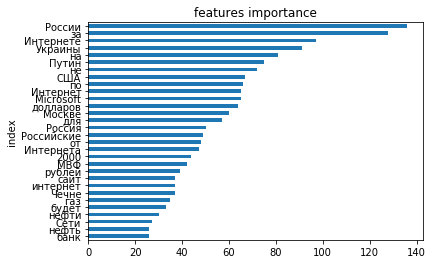

In [39]:
ts.tail(30).plot(kind="barh", title=("features importance"))

In [104]:
model.classes_

array(['69-я параллель', 'nan', 'Бывший СССР', 'Дом', 'Из жизни',
       'Интернет и СМИ', 'Крым', 'Культпросвет ', 'Культура', 'Мир',
       'Наука и техника', 'Оружие', 'Путешествия', 'Россия',
       'Силовые структуры', 'Спорт', 'Ценности', 'Экономика'], dtype=object)

In [134]:
ts = pd.DataFrame(columns=models[0][1].classes_,data=np.transpose(models[0][1].coef_),index=vectorizer.get_feature_names())
ts = ts.drop(["nan"], axis=1)
ts = ts.fillna(0)
ts

,69-я параллель,Бывший СССР,Дом,Из жизни,Интернет и СМИ,Крым,Культпросвет,Культура,Мир,Наука и техника,Оружие,Путешествия,Россия,Силовые структуры,Спорт,Ценности,Экономика
аба,-0.092523,-0.272396,-0.191325,0.013126,-0.402811,-0.066179,-0.051325,-0.272965,1.297093,-0.285349,-0.016854,0.271804,-0.224014,-0.262634,-0.206918,-0.025180,-0.235280
аба камаль,-0.063974,-0.165629,-0.118446,-0.149026,-0.272204,-0.046817,-0.036704,-0.167012,0.873962,-0.067305,-0.011938,-0.114514,-0.302406,-0.156113,-0.166662,-0.126972,-0.135406
абсолютно,-0.037514,0.107114,-0.086721,-0.222238,0.285144,0.183806,-0.020944,-0.015384,0.251342,-0.178759,-0.005974,0.060299,-0.202203,0.019608,-0.102311,-0.151368,0.092635
абсолютный,-0.053032,-0.143450,-0.113600,-0.155593,-0.148398,-0.027940,-0.023654,0.140842,-0.278378,-0.133008,-0.006967,-0.102173,0.053099,-0.083931,0.394947,0.145478,0.219708
абсолютный бойцовский,-0.023303,-0.056375,-0.032855,-0.111468,-0.071353,-0.013377,-0.010695,-0.091179,-0.130766,-0.068807,-0.003404,-0.036068,0.066170,-0.045505,0.530881,-0.051968,-0.066488
авак,-0.026598,0.846560,-0.050072,-0.058524,-0.111538,-0.032553,-0.016525,-0.072686,-0.201502,-0.063685,-0.004888,-0.041433,-0.283223,-0.202780,-0.077530,-0.047004,-0.129382
авакова,-0.043845,2.040281,-0.087945,-0.114935,-0.197013,-0.041044,-0.026550,-0.171845,-0.378163,-0.103871,-0.008159,-0.065275,-0.374118,-0.456159,-0.150707,-0.100872,-0.198260
аварийный,-0.050392,-0.036378,0.274722,0.077044,-0.146041,0.054677,-0.019708,-0.129701,-0.151213,0.006955,-0.006299,-0.089715,0.640172,-0.119300,-0.099611,-0.090321,-0.199962
авария,-0.117188,-0.239183,-0.182786,-0.160676,-0.469831,-0.070534,-0.051937,-0.242677,-0.266204,0.269905,-0.016971,-0.208814,1.647835,0.094968,0.354902,-0.308717,-0.181586
авария произойти,-0.020182,0.097756,-0.053025,-0.060452,-0.082789,-0.012217,-0.008869,-0.046033,-0.039906,-0.088825,-0.002936,-0.029399,0.200164,-0.074893,0.169441,-0.040103,-0.040237


In [136]:
ts.columns

Index(['69-я параллель', 'Бывший СССР', 'Дом', 'Из жизни', 'Интернет и СМИ',
       'Крым', 'Культпросвет ', 'Культура', 'Мир', 'Наука и техника', 'Оружие',
       'Путешествия', 'Россия', 'Силовые структуры', 'Спорт', 'Ценности',
       'Экономика'],
      dtype='object')

nan


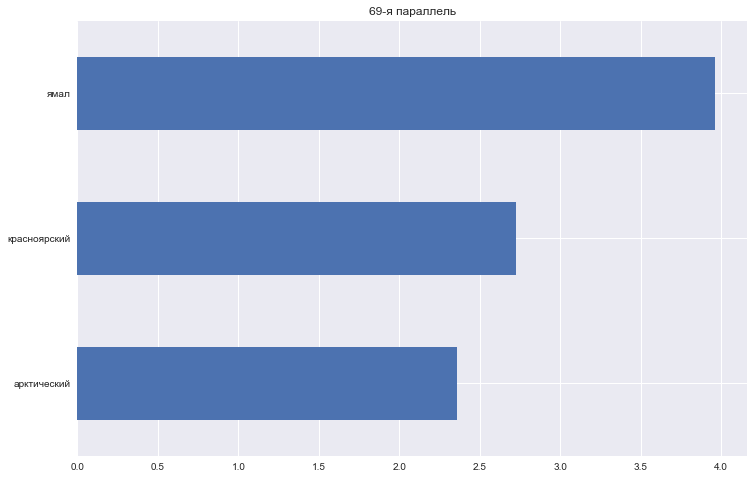

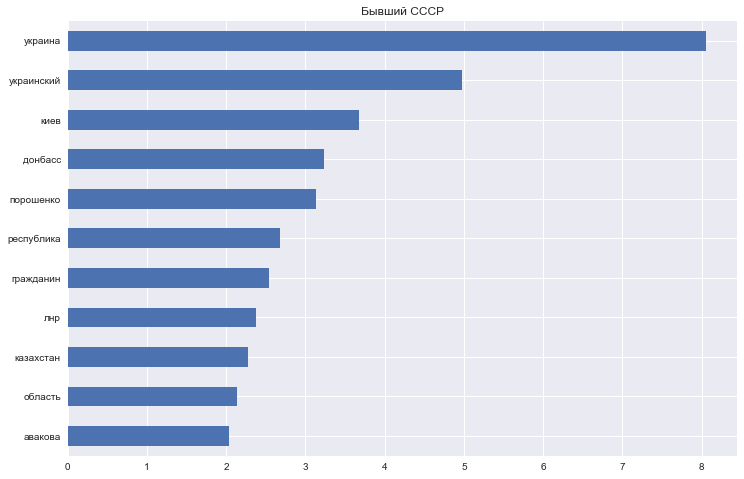

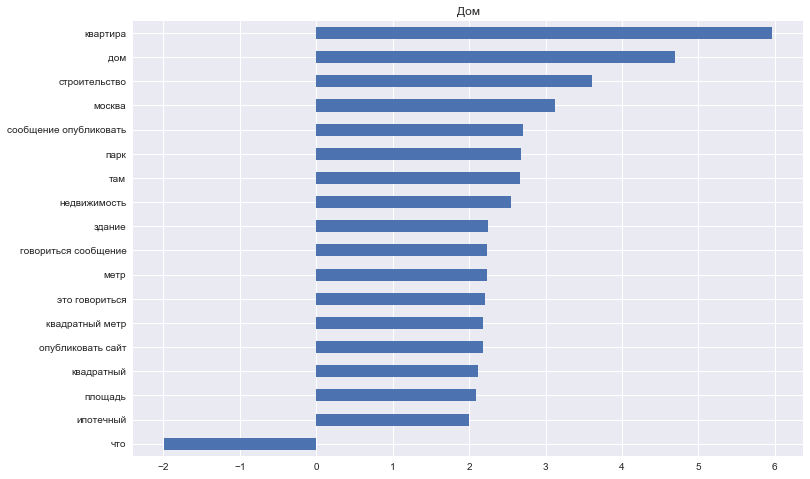

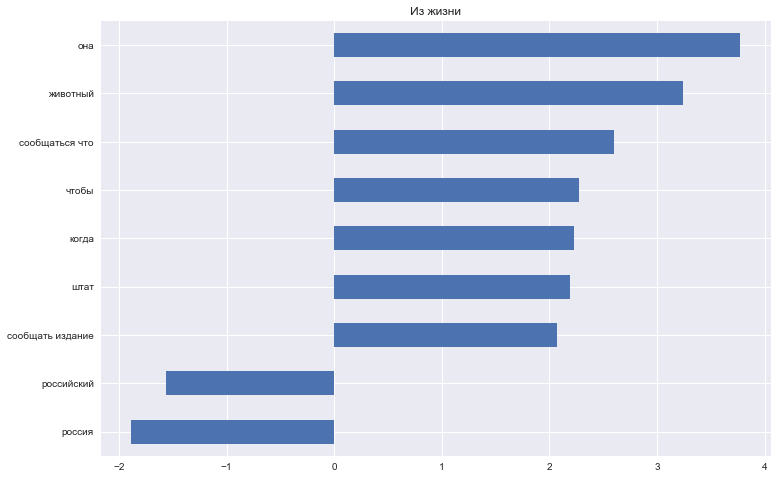

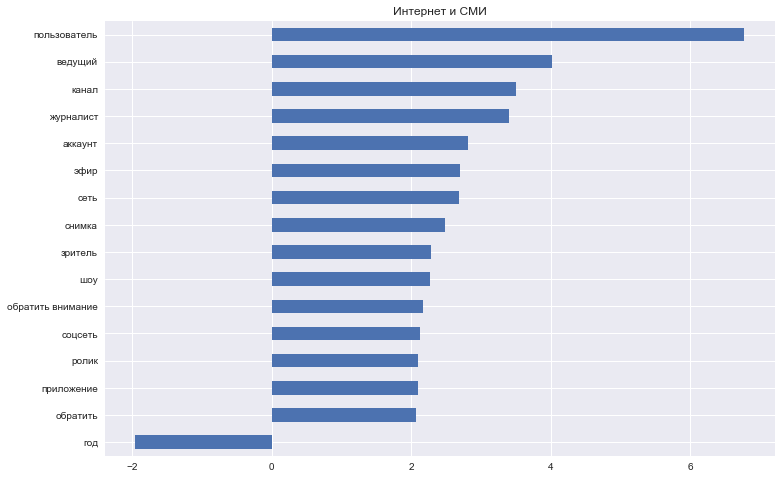

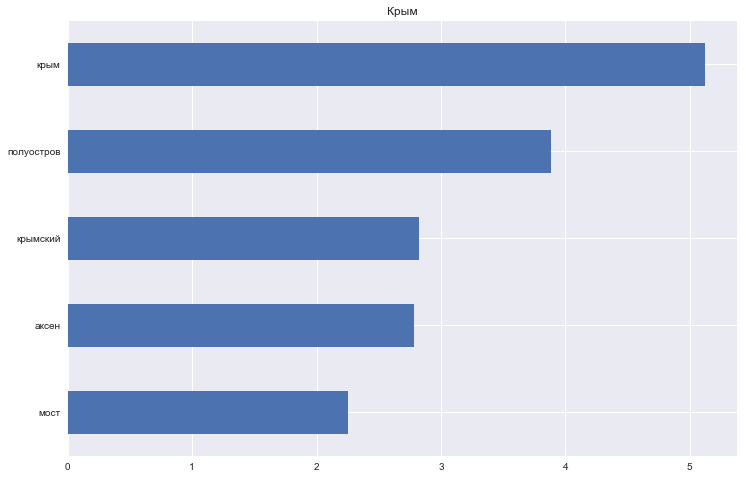

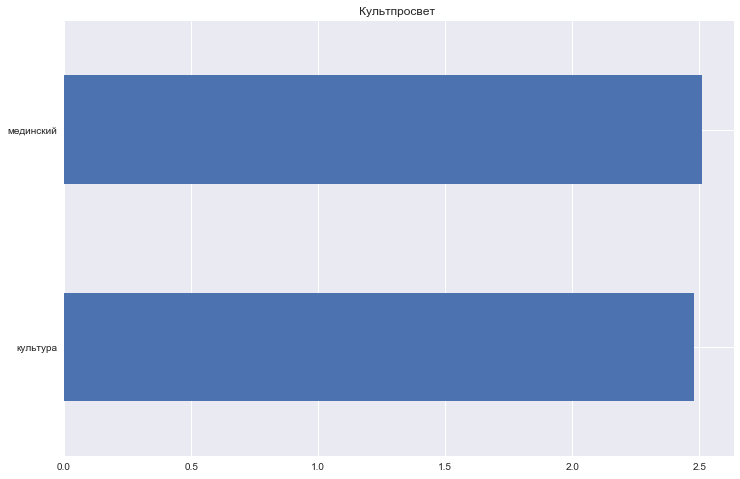

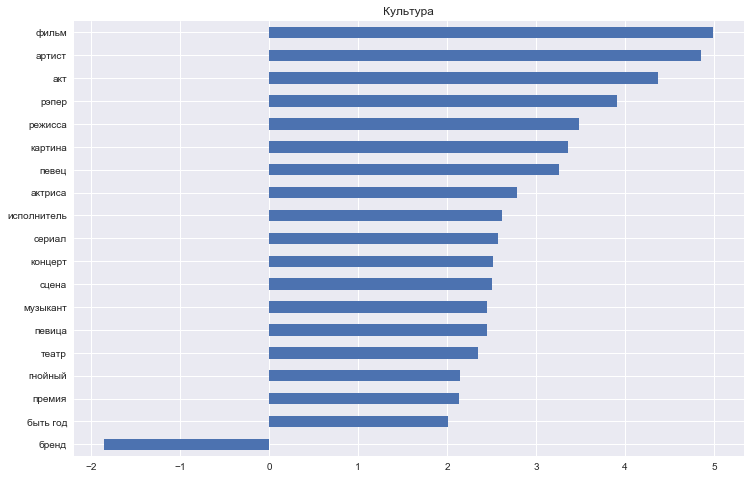

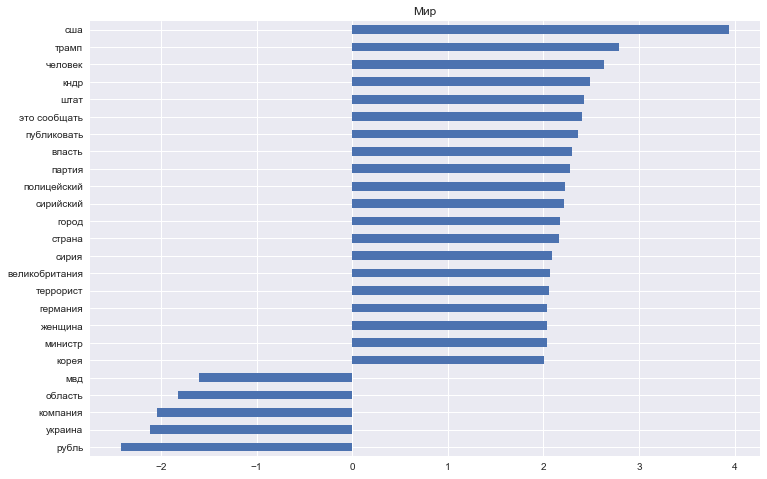

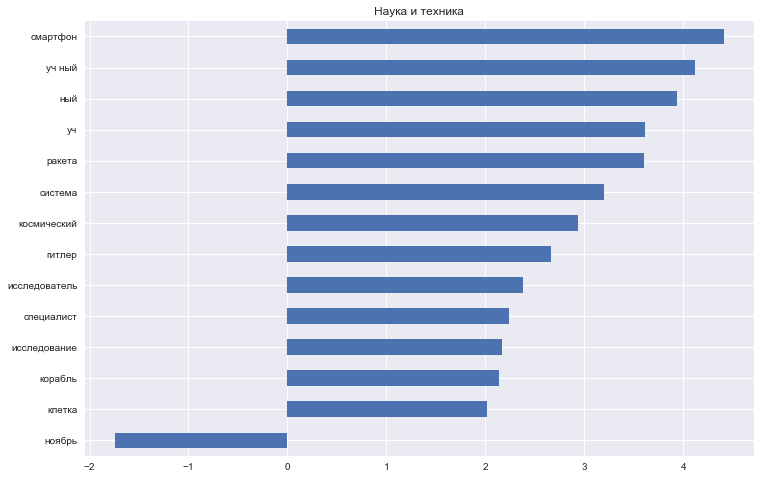

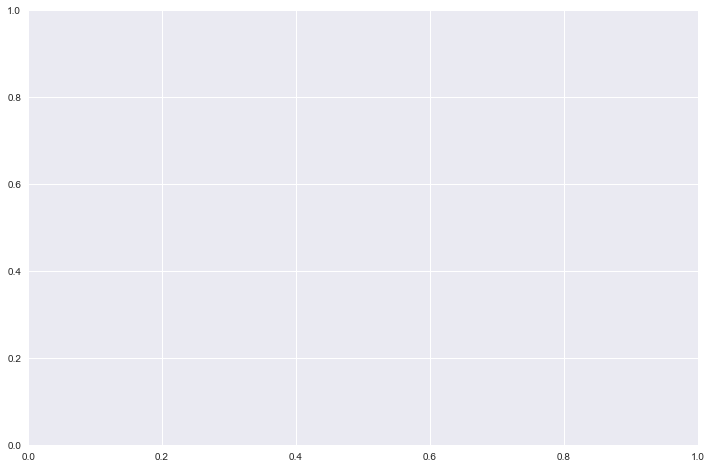

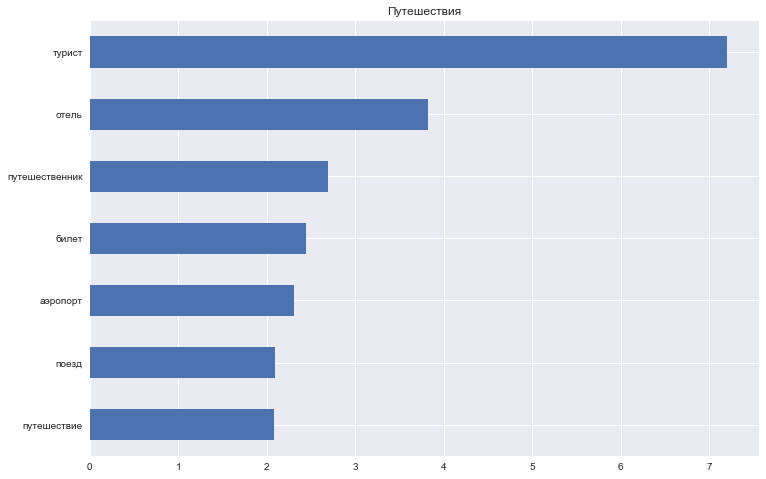

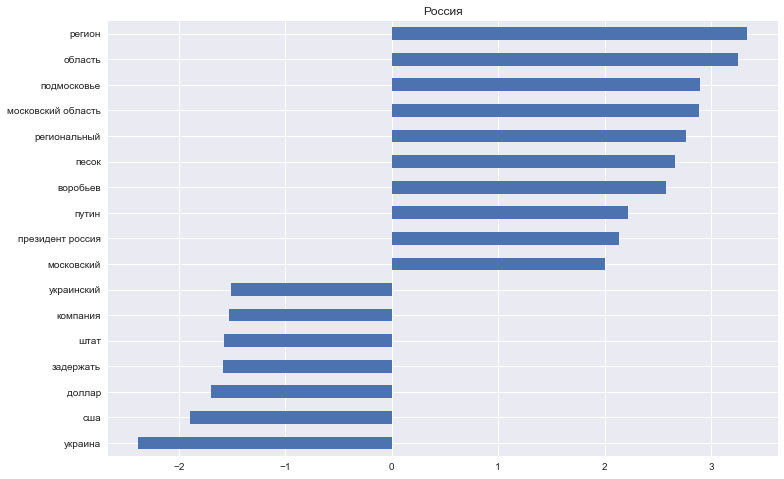

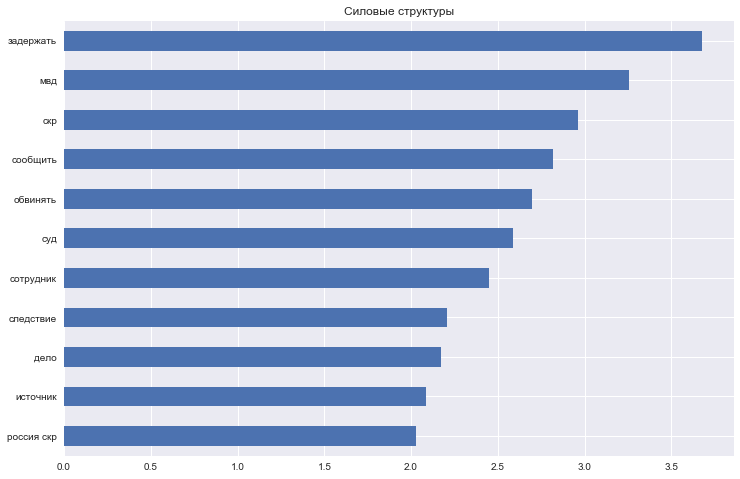

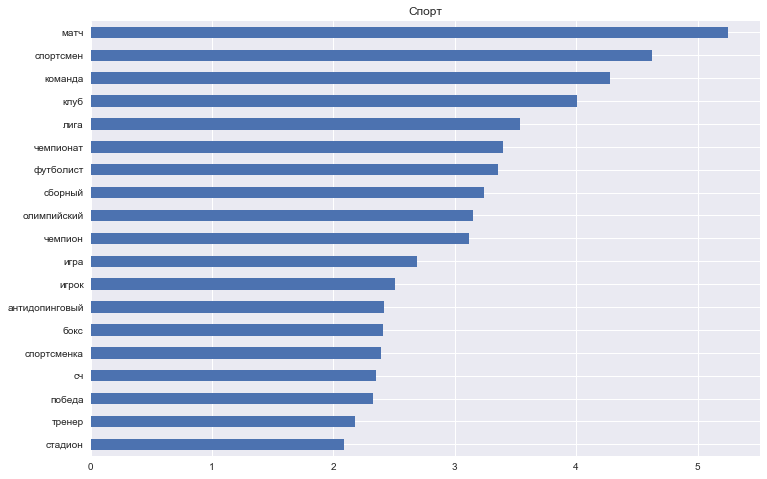

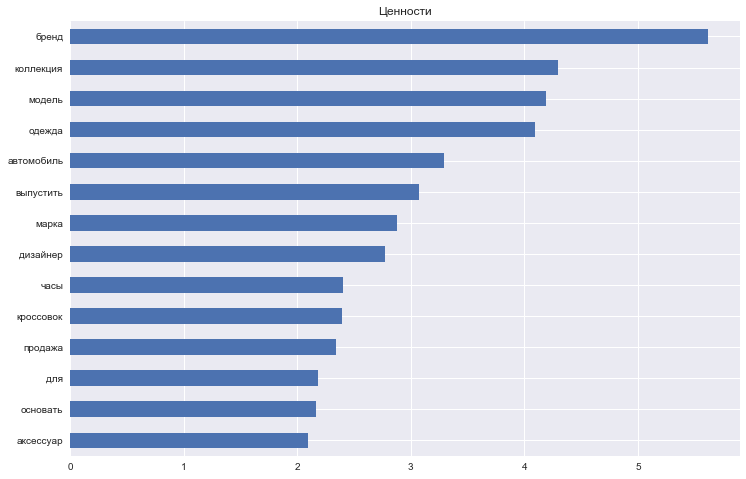

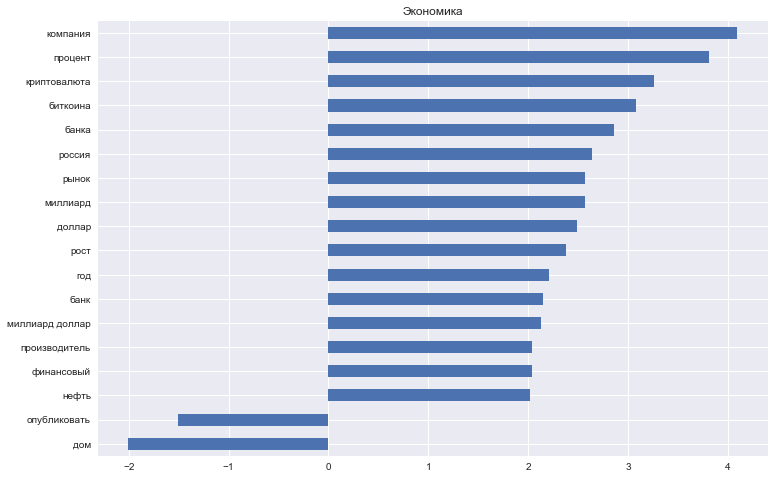

In [155]:
for c in ts.columns:
    try:
        plt.figure(figsize = (12, 8))
        ts[c][(ts[c] > 2) | (ts[c] < -1.5)].sort_values().plot(kind="barh", title=(c))
    except:
        print('nan')

# Кластеризация

In [4]:
# import armat_clustering

In [7]:
vectorizer=TfidfVectorizer(analyzer='word',
                           stop_words=[],
                           lowercase=False,
#                            ngram_range=(1, 2),
#                            min_df=0.2
                           )
tf_idf = vectorizer.fit_transform(data_short['text'])
words = vectorizer.get_feature_names()

In [12]:
cl_algor = armat_clustering.my_MiniBatchKMeans()
cl_algor.fit(armat_clustering.to_lsa(tf_idf))

LSA.n_components:  626
Trying to divide 5000 items to 255 clusters.


array(['002', '038', '020', ..., '014', '001', '001'], 
      dtype='<U6')

In [13]:
labels = cl_algor.labels_

In [17]:
clustering_df = armat_clustering.group_clusters(tf_idf, labels)

In [18]:
clustering_df

,label,docs,centroid
0,001,"[3, 7, 8, 12, 19, 22, 26, 27, 38, 39, 40, 52, ...","[0.000122651114627, 0.000129461902734, 8.65795..."
1,002,"[0, 4, 5, 6, 9, 25, 43, 46, 48, 55, 57, 60, 61...","[0.00298978333108, 0.000150756823091, 0.0, 0.0..."
2,003,"[156, 239, 277, 516, 585, 1056, 1122, 1194, 12...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,004,"[16, 76, 113, 154, 240, 251, 267, 280, 304, 30...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,005,"[123, 139, 230, 245, 367, 664, 681, 886, 1001,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,006,"[109, 117, 129, 171, 229, 236, 248, 257, 266, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,007,"[56, 87, 127, 176, 180, 283, 338, 345, 373, 38...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.00116143326696, 0...."
7,008,"[18, 24, 68, 276, 336, 686, 978, 980, 1162, 12...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,009,"[136, 288, 359, 400, 518, 565, 657, 661, 733, ...","[0.00636644277449, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
9,010,"[211, 334, 381, 397, 455, 458, 1297, 1321, 152...","[0.0, 0.0, 0.00162852244684, 0.0, 0.0, 0.0, 0...."


In [20]:
clustering_df['best_words'] = clustering_df['centroid'].apply(lambda row: armat_clustering.get_top_words(row, words))

In [21]:
clustering_df

,label,docs,centroid,best_words
0,001,"[3, 7, 8, 12, 19, 22, 26, 27, 38, 39, 40, 52, ...","[0.000122651114627, 0.000129461902734, 8.65795...","[что, на, не, из, по]"
1,002,"[0, 4, 5, 6, 9, 25, 43, 46, 48, 55, 57, 60, 61...","[0.00298978333108, 0.000150756823091, 0.0, 0.0...","[на, по, из, что, ноября]"
2,003,"[156, 239, 277, 516, 585, 1056, 1122, 1194, 12...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[одежды, коллекцию, бренд, аксессуаров, бренда]"
3,004,"[16, 76, 113, 154, 240, 251, 267, 280, 304, 30...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[процента, процентов, на, рублей, года]"
4,005,"[123, 139, 230, 245, 367, 664, 681, 886, 1001,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[рублей, на, миллиона, квадратных, рынке]"
5,006,"[109, 117, 129, 171, 229, 236, 248, 257, 266, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Московской, области, Воробьев, региона, Подмо..."
6,007,"[56, 87, 127, 176, 180, 283, 338, 345, 373, 38...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.00116143326696, 0....","[МОК, Сочи, Олимпийских, медалей, 2014]"
7,008,"[18, 24, 68, 276, 336, 686, 978, 980, 1162, 12...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[ИГ, Сирии, боевиков, Исламское, государство]"
8,009,"[136, 288, 359, 400, 518, 565, 657, 661, 733, ...","[0.00636644277449, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[мира, 2018, футболу, пройдет, городах]"
9,010,"[211, 334, 381, 397, 455, 458, 1297, 1321, 152...","[0.0, 0.0, 0.00162852244684, 0.0, 0.0, 0.0, 0....","[водитель, ДТП, на, сбил, ГИБДД]"
